# PUBG玩家落点和吃鸡概率分析

## 一.数据准备
### 1.导入所需的库

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys

sns.set_style('darkgrid')
sns.set_palette('bone')

#pd.options.display.float_format = '{:.5g}'.format
pd.options.display.float_format = '{:,.3f}'.format

print(os.listdir("./pubg-finish-placement-prediction"))

['sample_submission_V2.csv', 'test_V2.csv', 'train_V2.csv']


## 2.定义

In [4]:
def toTupleList(list1,list2):
    """
    把两个列表转为笛卡尔积形式
    """
    return list(itertools.product(list1,list2))

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
%%time
train = pd.read_csv('./pubg-finish-placement-prediction/train_V2.csv')
train = reduce_mem_usage(train)
test = pd.read_csv('./pubg-finish-placement-prediction/test_V2.csv')
test = reduce_mem_usage(test)
print(train.shape, test.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(4446966, 29) (1934174, 28)
CPU times: total: 14 s
Wall time: 19.8 s


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

In [8]:
null_cnt = train.isnull().sum().sort_values()
print('null count:', null_cnt[null_cnt > 0])
# dropna
train.dropna(inplace=True)

null count: winPlacePerc    1
dtype: int64


In [9]:
train.describe(include=np.number).drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.234,0.589,0.000,0.000,0.000,0.000,22.000
boosts,1.107,1.716,0.000,0.000,0.000,2.000,33.000
damageDealt,130.633,169.887,0.000,0.000,84.240,186.000,"6,616.000"
DBNOs,0.658,1.146,0.000,0.000,0.000,1.000,53.000
headshotKills,0.227,0.602,0.000,0.000,0.000,0.000,64.000
heals,1.370,2.680,0.000,0.000,0.000,2.000,80.000
killPlace,47.599,27.463,1.000,24.000,47.000,71.000,101.000
killPoints,505.006,627.505,0.000,0.000,0.000,"1,172.000","2,170.000"
kills,0.925,1.558,0.000,0.000,0.000,1.000,72.000
killStreaks,0.544,0.711,0.000,0.000,0.000,1.000,20.000


In [10]:
for c in ['Id','groupId','matchId']:
    print(f'unique [{c}] count:', train[c].nunique())

unique [Id] count: 4446965
unique [groupId] count: 2026744
unique [matchId] count: 47964


<AxesSubplot:>

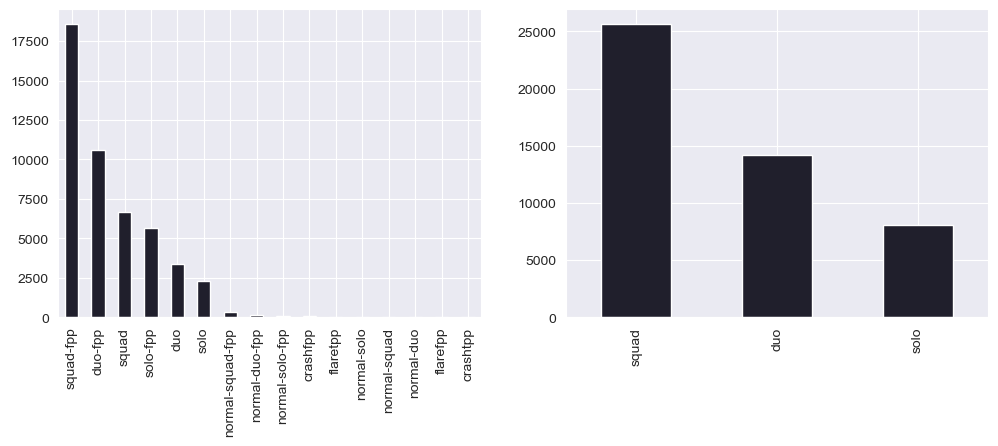

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[0])

'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
train['matchType'] = train['matchType'].apply(mapper)
train.groupby('matchId')['matchType'].first().value_counts().plot.bar(ax=ax[1])

In [12]:
for q in ['numGroups == maxPlace','numGroups != maxPlace']:
    print(q, ':', len(train.query(q)))

numGroups == maxPlace : 1241089
numGroups != maxPlace : 3205876


In [13]:
# describe
cols = ['numGroups','maxPlace']
desc1 = train.groupby('matchType')[cols].describe()[toTupleList(cols,['min','mean','max'])]
# groups in match
group = train.groupby(['matchType','matchId','groupId']).count().groupby(['matchType','matchId']).size().to_frame('groups in match')
desc2 = group.groupby('matchType').describe()[toTupleList(['groups in match'],['min','mean','max'])]

pd.concat([desc1, desc2], axis=1)

numGroups                maxPlace                groups in match  \
                min   mean     max      min   mean     max             min   
matchType                                                                    
duo           1.000 45.812  52.000    3.000 47.609  52.000           1.000   
solo          1.000 91.115 100.000    2.000 93.909 100.000           1.000   
squad         2.000 27.039  37.000    2.000 27.983  37.000           2.000   

                          
            mean     max  
matchType                 
duo       45.349  52.000  
solo      85.680 100.000  
squad     26.835  37.000

In [14]:
match = train.groupby(['matchType','matchId']).size().to_frame('players in match')
group = train.groupby(['matchType','matchId','groupId']).size().to_frame('players in group')
pd.concat([match.groupby('matchType').describe()[toTupleList(['players in match'],['min','mean','max'])], 
           group.groupby('matchType').describe()[toTupleList(['players in group'],['min','mean','max'])]], axis=1)

players in match                players in group             
                       min   mean     max              min  mean    max
matchType                                                              
duo                  7.000 92.986 100.000            1.000 2.050 72.000
solo                 2.000 89.043 100.000            1.000 1.039 64.000
squad                5.000 93.723 100.000            1.000 3.493 74.000

In [15]:
print(group['players in group'].nlargest(5))
del match,group

matchType  matchId         groupId       
squad      b30f3d87189aa6  14d6b54cdec6bc    74
duo        3e029737889ce9  b8275198faa03b    72
solo       41a634f62f86b7  128b07271aa012    64
duo        7e93ce71ac6f61  7385e5fe214021    49
squad      3c2531adf5b942  e52a2e6ca30474    36
Name: players in group, dtype: int64


In [16]:
''' ex) matchId=='41a634f62f86b7', groupId=='128b07271aa012'
'''
subset = train[train['matchId']=='41a634f62f86b7']
sub_grp = subset[subset['groupId']=='128b07271aa012']

print('matchId==\'41a634f62f86b7\' & groupId==\'128b07271aa012\'')
print('-'*50)
print('players:',len(subset))
print('groups:',subset['groupId'].nunique())
print('numGroups:',subset['numGroups'].unique())
print('maxPlace:',subset['maxPlace'].unique())
print('-'*50)
print('max-group players:',len(sub_grp))
print('max-group winPlacePerc:',sub_grp['winPlacePerc'].unique())
print('-'*50)
print('winPlacePerc:',subset['winPlacePerc'].sort_values().unique())

matchId=='41a634f62f86b7' & groupId=='128b07271aa012'
--------------------------------------------------
players: 97
groups: 34
numGroups: [34]
maxPlace: [97]
--------------------------------------------------
max-group players: 64
max-group winPlacePerc: [0.2812]
--------------------------------------------------
winPlacePerc: [0.     0.0104 0.0208 0.0312 0.0417 0.0521 0.0625 0.0729 0.0833 0.0938
 0.1042 0.1146 0.125  0.1354 0.1458 0.1562 0.1667 0.1771 0.1875 0.1979
 0.2083 0.2188 0.2292 0.2396 0.25   0.2604 0.2708 0.2812 0.7604 0.7708
 0.8958 0.9167 0.9896 1.    ]


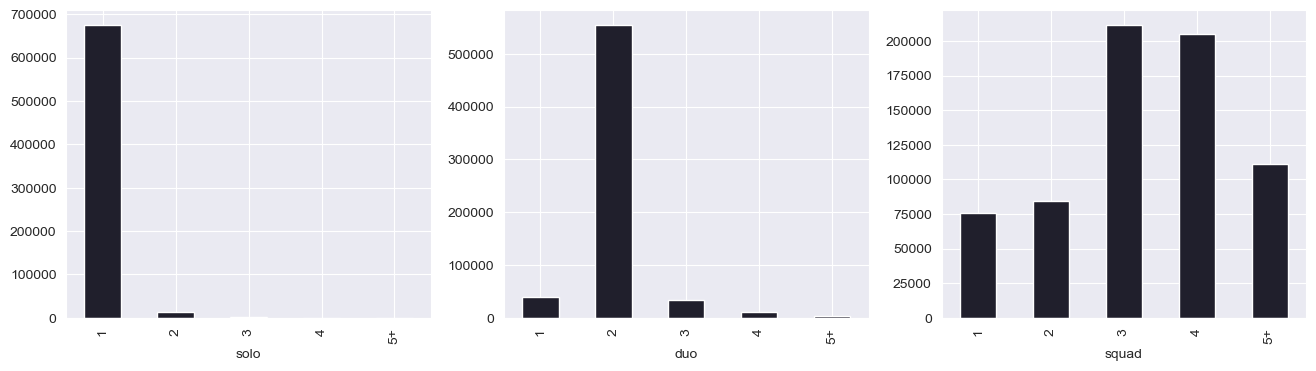

In [17]:
group = train.groupby(['matchId','groupId','matchType'])['Id'].count().to_frame('players').reset_index()
group.loc[group['players'] > 4, 'players'] = '5+'
group['players'] = group['players'].astype(str)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for mt, ax in zip(['solo','duo','squad'], ax.ravel()):
    ax.set_xlabel(mt)
    group[group['matchType'] == mt]['players'].value_counts().sort_index().plot.bar(ax=ax)

<AxesSubplot:>

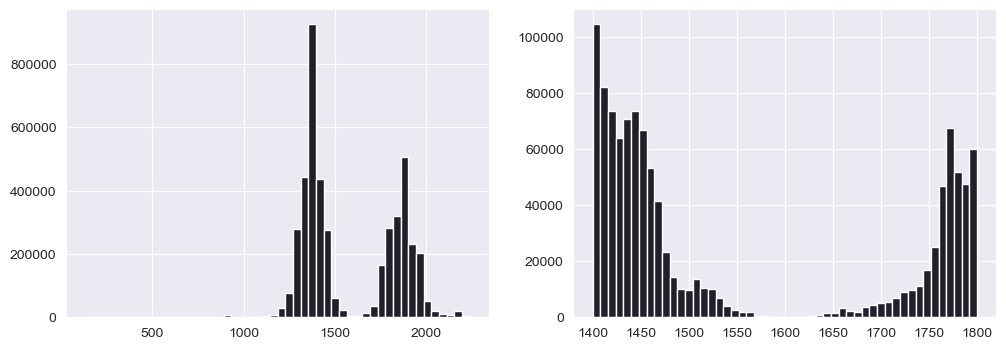

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# there are two types of maps?
train['matchDuration'].hist(bins=50, ax=ax[0])
train.query('matchDuration >= 1400 & matchDuration <= 1800')['matchDuration'].hist(bins=50, ax=ax[1])

In [19]:
train[train['matchDuration'] == train['matchDuration'].min()].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
1206365,28f2bb56074e95,311a5a9adf1a96,e5a77433bc436f,0,0,100.000,0,1,0,1,...,0,0.000,0,0.000,0,0,0.280,2,0,1.000
2109739,2a5f4f18fe9e86,f290930a32548a,e5a77433bc436f,0,0,0.000,0,0,0,2,...,0,0.000,0,0.000,0,0,0.000,2,0,0.000


In [20]:
train[train['matchDuration'] == train['matchDuration'].max()].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
130663,8089c9ef1fa09e,3c909156e89431,f8e02cb4c82d7d,0,0,0.000,0,0,0,72,...,0,0.000,0,0.000,0,0,231.800,3,0,0.260
139317,3049d51e07bab3,4086a790e99513,f8e02cb4c82d7d,0,0,100.000,0,0,0,34,...,0,0.000,0,0.000,0,0,696.000,7,0,0.458
146220,cb3902c30f688c,65400d5cf84ead,f8e02cb4c82d7d,0,0,0.000,0,0,0,85,...,0,0.000,0,0.000,0,0,99.950,1,0,0.125
246201,80e022ce3a64ff,b668e37229bb2d,f8e02cb4c82d7d,0,1,96.250,0,1,0,35,...,0,0.000,0,0.000,0,0,"1,395.000",6,0,0.375
268239,0e50a3a859d3ab,9dcca2c1beb072,f8e02cb4c82d7d,0,0,0.000,0,0,0,41,...,0,0.000,0,0.000,0,0,121.700,3,0,0.906


In [21]:
(train.groupby('matchId')['matchDuration'].nunique() > 1).any()

False

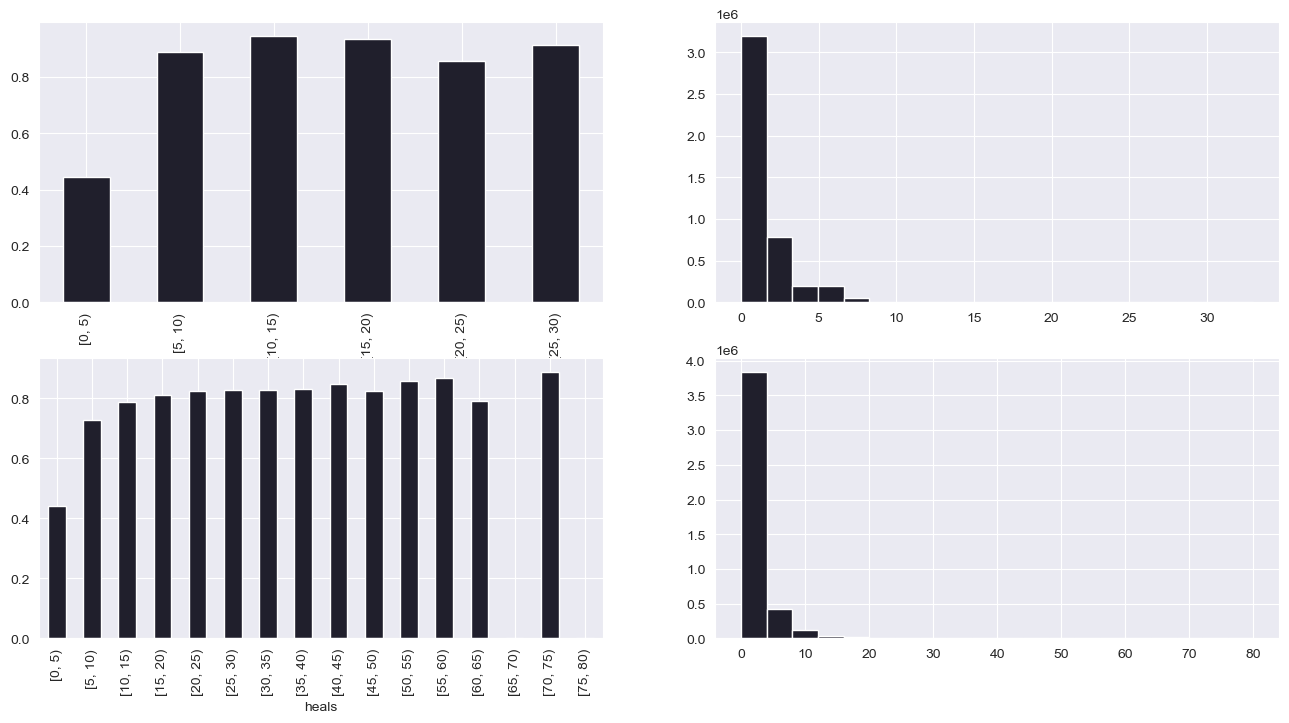

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

cols = ['boosts','heals']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc',col]].copy()
    mv = (sub[col].max() // 5) + 1
    sub[col] = pd.cut(sub[col], [5*x for x in range(0,mv)], right=False)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

In [23]:
print('solo player has revives:', 'solo' in train.query('revives > 0')['matchType'].unique())

solo player has revives: False


<AxesSubplot:>

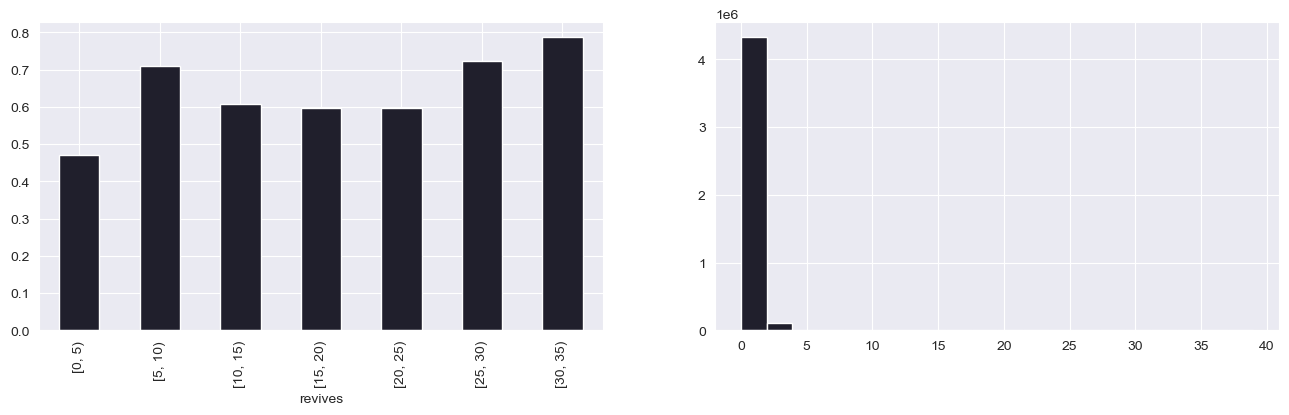

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
col = 'revives'
sub = train.loc[~train['matchType'].str.contains('solo'),['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [5*x for x in range(0,8)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

In [25]:
train.groupby(['matchType'])['killPlace'].describe()[['min','mean','max']]

,min,mean,max
matchType,,,
duo,1.000,47.471,100.000
solo,1.000,47.458,100.000
squad,1.000,47.712,101.000


<AxesSubplot:xlabel='killPlace'>

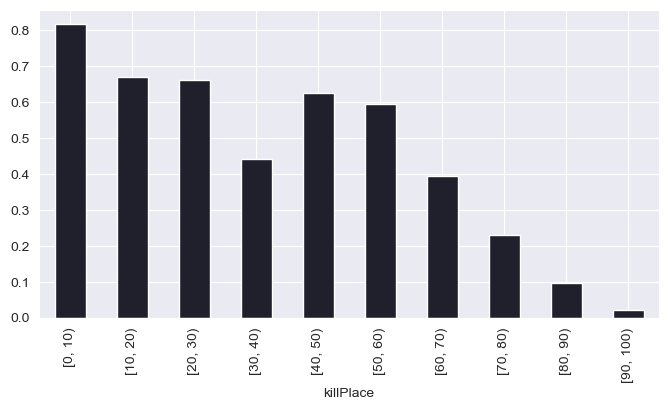

In [26]:
plt.figure(figsize=(8,4))
col = 'killPlace'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [10*x for x in range(0,11)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar()

In [27]:
''' important 
'''
subMatch = train[train['matchId'] == train['matchId'].min()].sort_values(['winPlacePerc','killPlace'])
cols = ['groupId','kills','winPlacePerc','killPlace']
subMatch[cols]


,groupId,kills,winPlacePerc,killPlace
3895898,3a6addfa0df938,0,0.000,94
3599150,3a6addfa0df938,0,0.000,95
4367296,236ab9e9c081b9,0,0.037,88
4131025,236ab9e9c081b9,0,0.037,89
3088817,236ab9e9c081b9,0,0.037,90
...,...,...,...,...
1303528,ca058240046b4c,6,0.963,3
3637258,ca058240046b4c,5,0.963,6
2351120,ca058240046b4c,1,0.963,24
2848198,4d1bbbc19b9084,5,1.000,5


<AxesSubplot:>

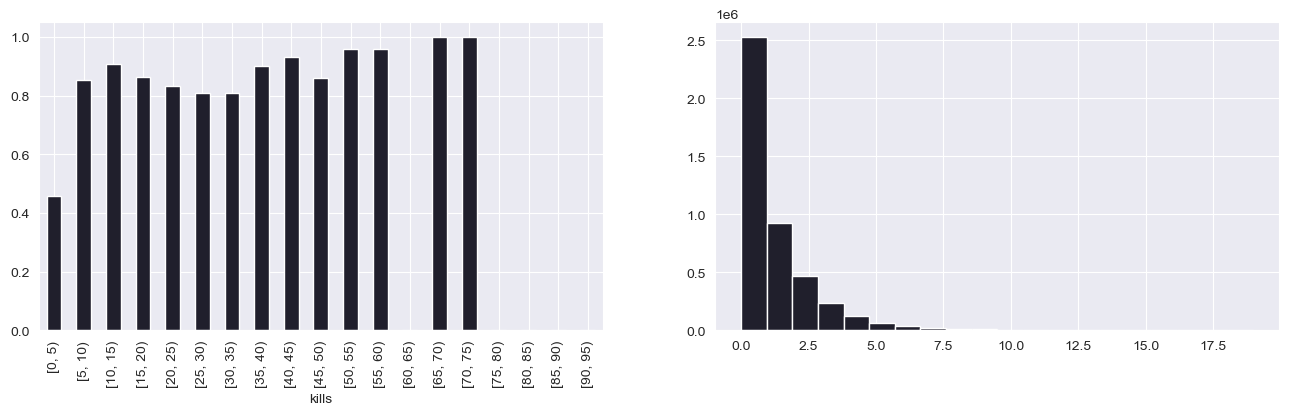

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'kills'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], [5*x for x in range(0,20)], right=False)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[train['kills'] < 20][col].hist(bins=20, ax=ax[1])

In [29]:
sub = train['matchType'].str.contains('solo')
pd.concat([train.loc[sub].groupby('matchId')['kills'].sum().describe(),
         train.loc[~sub].groupby('matchId')['kills'].sum().describe()], keys=['solo','team'], axis=1).T

,count,mean,std,min,25%,50%,75%,max
solo,"8,094.000",83.421,27.592,0.000,84.000,89.000,92.000,786.000
team,"39,870.000",86.212,17.269,0.000,83.000,87.000,90.000,687.000


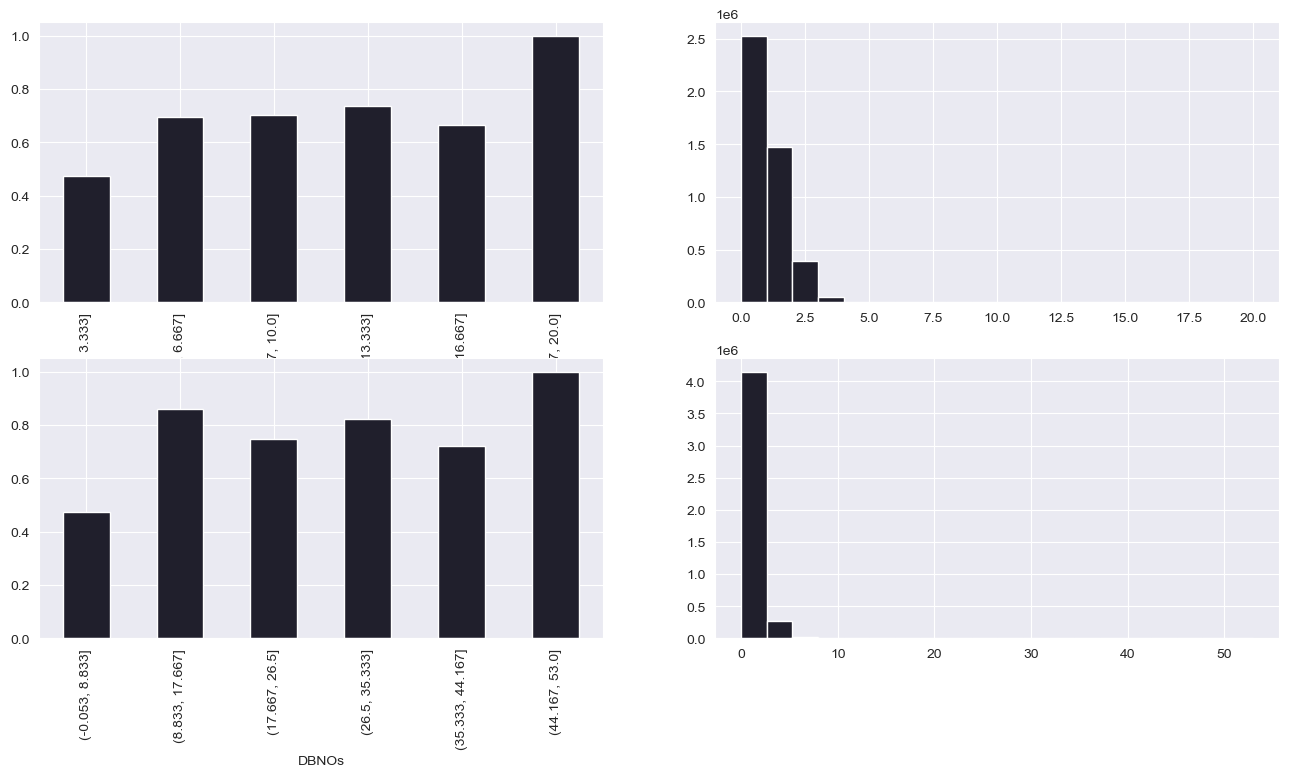

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

cols = ['killStreaks','DBNOs']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc',col]].copy()
    sub[col] = pd.cut(sub[col], 6)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

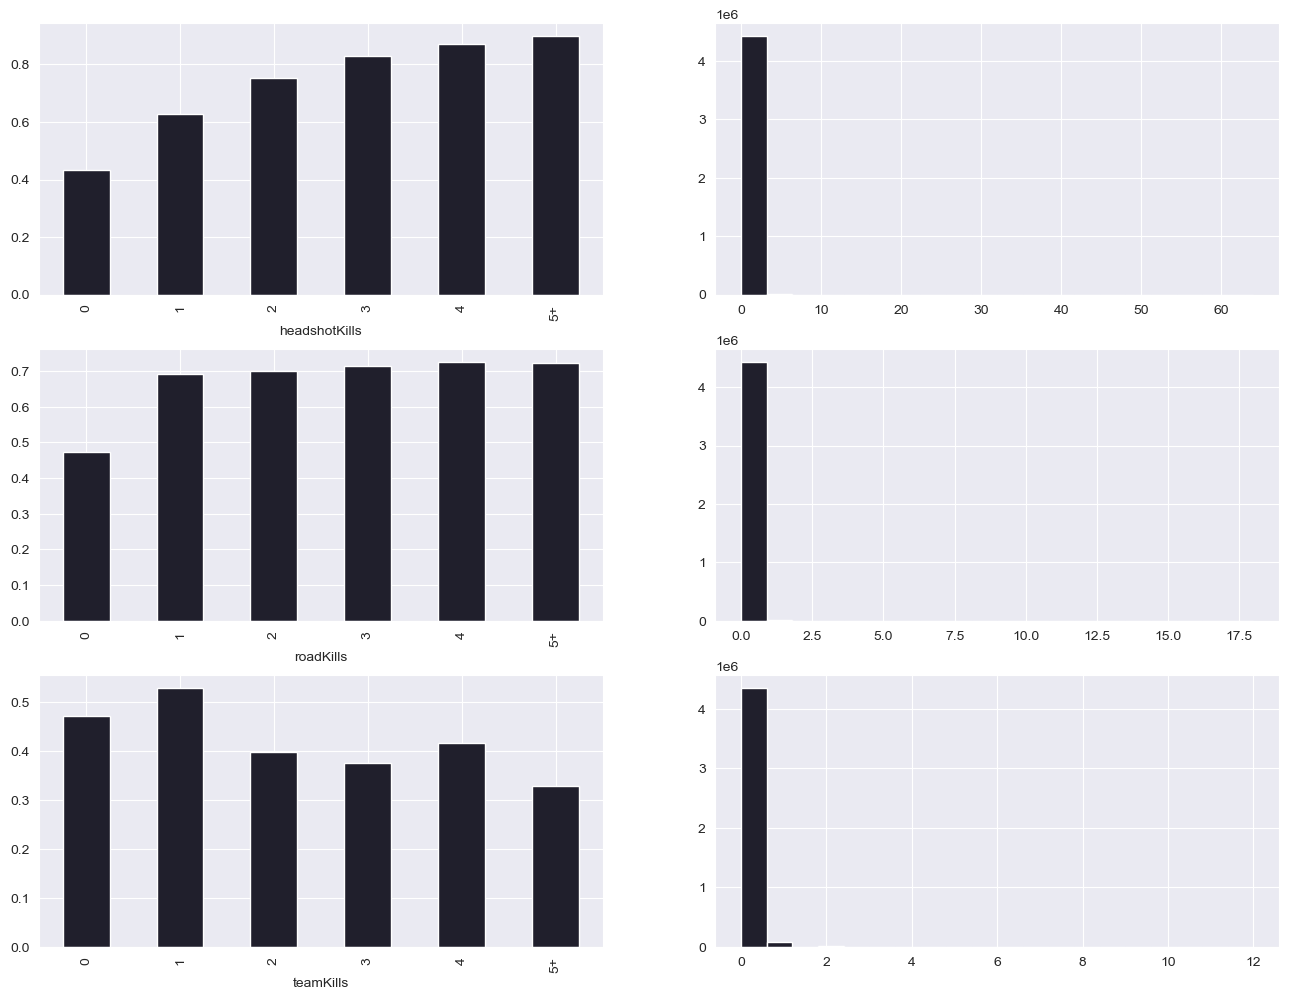

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

cols = ['headshotKills','roadKills','teamKills']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc',col]].copy()
    sub.loc[sub[col] >= 5, col] = '5+'  
    sub[col] = sub[col].astype(str)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

<AxesSubplot:>

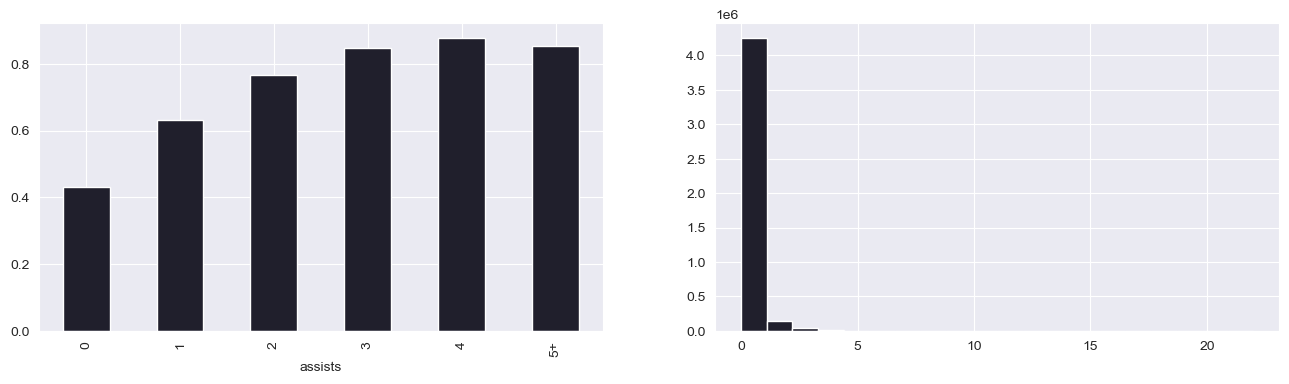

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'assists'
sub = train[['winPlacePerc',col]].copy()
sub.loc[sub[col] >= 5, col] = '5+'  
sub[col] = sub[col].astype(str)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

In [33]:
pd.concat([train[train['matchType'] == 'solo'].describe()['assists'],
           train[train['matchType'] != 'solo'].describe()['assists']],
          keys=['solo','team'], axis=1).T

,count,mean,std,min,25%,50%,75%,max
solo,"720,712.000",0.062,0.298,0.000,0.000,0.000,0.000,22.000
team,"3,726,253.000",0.267,0.624,0.000,0.000,0.000,0.000,17.000


<AxesSubplot:>

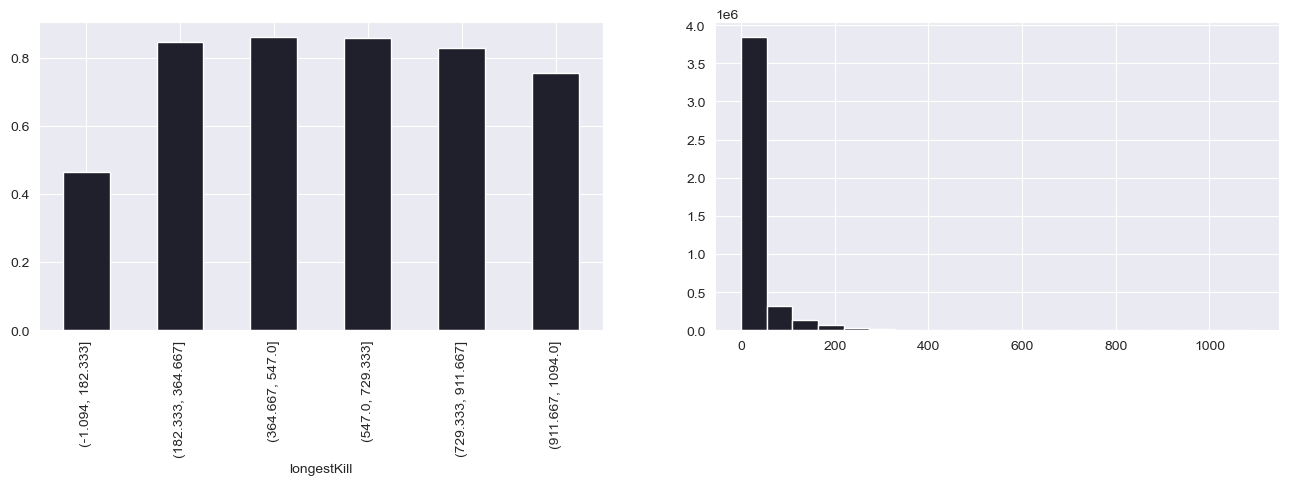

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'longestKill'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], 6)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

<AxesSubplot:>

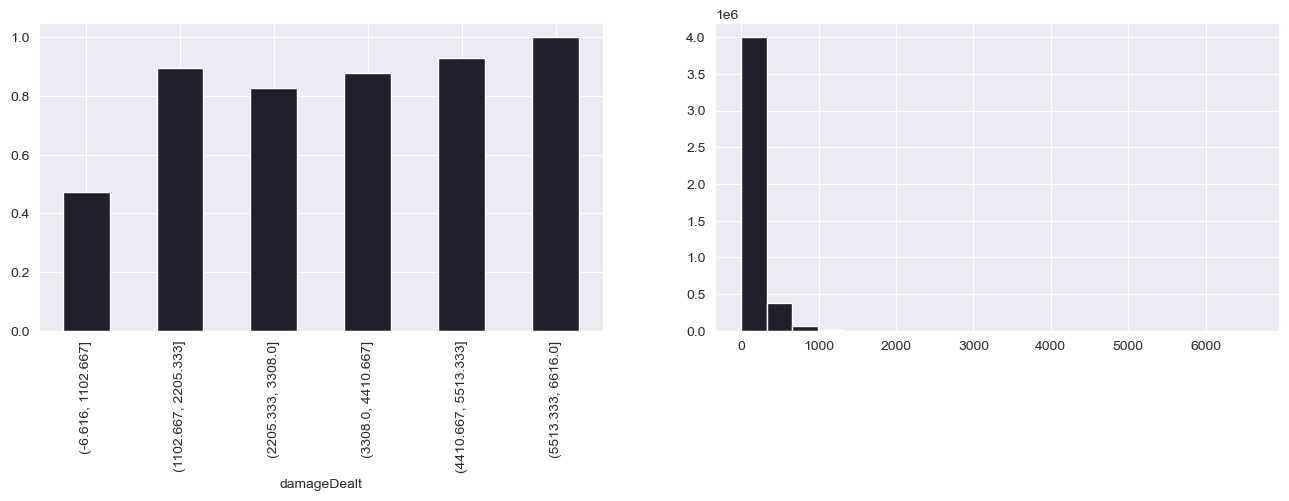

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

col = 'damageDealt'
sub = train[['winPlacePerc',col]].copy()
sub[col] = pd.cut(sub[col], 6)
sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
train[col].hist(bins=20, ax=ax[1])

In [36]:
train.query('damageDealt == 0 & (kills > 0 | DBNOs > 0)')[
    ['damageDealt','kills','DBNOs','headshotKills','roadKills','teamKills']].head(20)

,damageDealt,kills,DBNOs,headshotKills,roadKills,teamKills
150,0.000,0,1,0,0,1
589,0.000,0,1,0,0,0
707,0.000,0,1,0,0,0
892,0.000,1,0,0,0,0
942,0.000,1,0,0,0,0
949,0.000,0,1,0,0,2
1011,0.000,0,1,0,0,0
1468,0.000,0,2,0,0,1
1625,0.000,0,1,0,0,1
2111,0.000,0,1,0,0,1


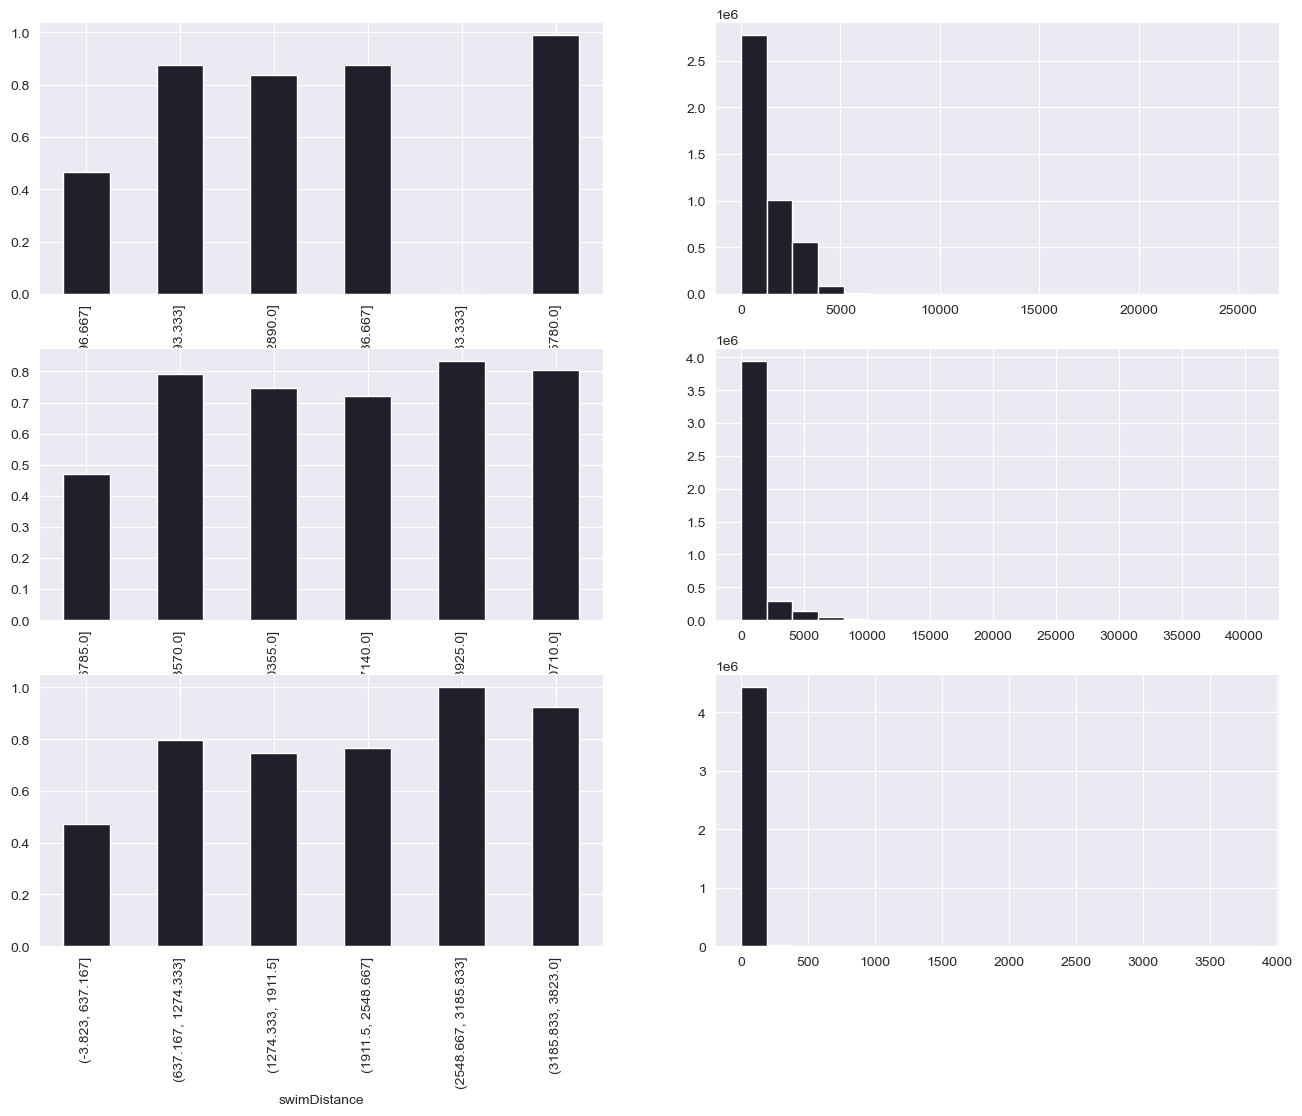

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

cols = ['walkDistance', 'rideDistance', 'swimDistance']
for col, ax in zip(cols, ax):
    sub = train[['winPlacePerc',col]].copy()
    sub[col] = pd.cut(sub[col], 6)
    sub.groupby(col).mean()['winPlacePerc'].plot.bar(ax=ax[0])
    train[col].hist(bins=20, ax=ax[1])

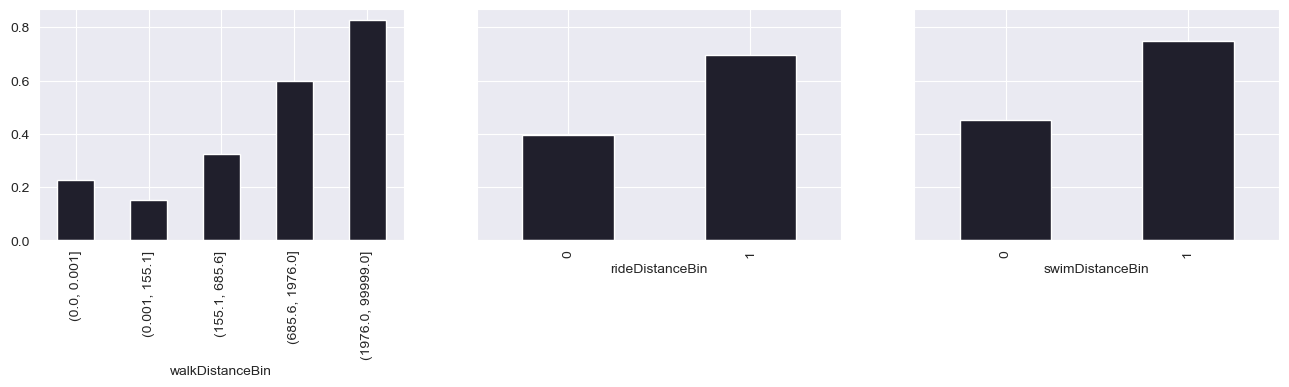

In [38]:
sub = train[['walkDistance','rideDistance','swimDistance','winPlacePerc']].copy()
walk = train['walkDistance']
sub['walkDistanceBin'] = pd.cut(walk, [0, 0.001, walk.quantile(.25), walk.quantile(.5), walk.quantile(.75), 99999])
sub['rideDistanceBin'] = (train['rideDistance'] > 0).astype(int)
sub['swimDistanceBin'] = (train['swimDistance'] > 0).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(16, 3), sharey=True)
sub.groupby('walkDistanceBin').mean()['winPlacePerc'].plot.bar(ax=ax[0])
sub.groupby('rideDistanceBin').mean()['winPlacePerc'].plot.bar(ax=ax[1])
sub.groupby('swimDistanceBin').mean()['winPlacePerc'].plot.bar(ax=ax[2])
del sub, walk

In [39]:
sub = train.query('walkDistance == 0 & kills == 0 & weaponsAcquired == 0 & \'solo\' in matchType')
print('count:', len(sub), ' winPlacePerc:', round(sub['winPlacePerc'].mean(),3))

count: 18154  winPlacePerc: 0.053


In [40]:
sq = 'kills > 3 & (headshotKills / kills) >= 0.8'
sub = train.query(sq)
print(sq, '\n count:', len(sub), ' winPlacePerc:', round(sub['winPlacePerc'].mean(),3))

kills > 3 & (headshotKills / kills) >= 0.8 
 count: 3859  winPlacePerc: 0.824


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


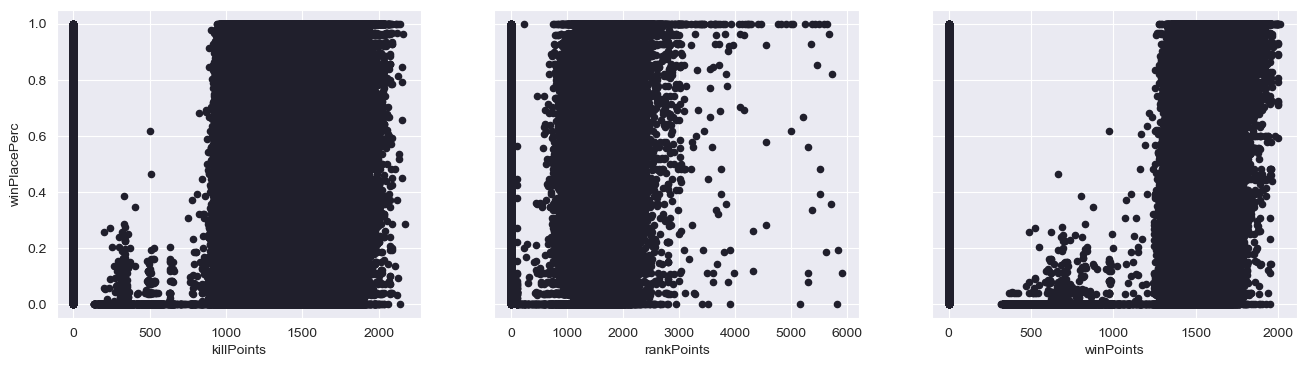

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

cols = ['killPoints','rankPoints','winPoints']
for col, ax in zip(cols, ax.ravel()): 
    train.plot.scatter(x=col, y='winPlacePerc', ax=ax)

In [42]:
# rankPoint: being deprecated
# killPoints,winPoints: If there is a value other than -1 in rankPoints, then any 0 should be treated as a “None”.
sign = lambda x: 'p<=0' if x <= 0 else 'p>0'
pd.concat([
    pd.crosstab(train['rankPoints'].apply(sign), train['winPoints'].apply(sign), margins=False),
    pd.crosstab(train['rankPoints'].apply(sign), train['killPoints'].apply(sign), margins=False)
], keys=['winPoints','killPoints'], axis=1)

winPoints          killPoints         
winPoints       p<=0      p>0       p<=0      p>0
rankPoints                                       
p<=0               0  1791319          0  1791319
p>0          2655646        0    2655646        0

In [43]:
train['winPlacePerc'].describe()

count   4,446,965.000
mean            0.473
std             0.307
min             0.000
25%             0.200
50%             0.458
75%             0.741
max             1.000
Name: winPlacePerc, dtype: float64

In [44]:
print('match count:', train['matchId'].nunique())

# not contains 1st place
maxPlacePerc = train.groupby('matchId')['winPlacePerc'].max()
print('match [not contains 1st place]:', len(maxPlacePerc[maxPlacePerc != 1]))
del maxPlacePerc

# edge case
sub = train[(train['maxPlace'] > 1) & (train['numGroups'] == 1)]
print('match [maxPlace>1 & numGroups==1]:', len(sub.groupby('matchId')))
print(' - unique winPlacePerc:', sub['winPlacePerc'].unique())

match count: 47964
match [not contains 1st place]: 74
match [maxPlace>1 & numGroups==1]: 68
 - unique winPlacePerc: [0.]


In [45]:
pd.concat([train[train['winPlacePerc'] == 1].head(5),
           train[train['winPlacePerc'] == 0].head(5)],
          keys=['winPlacePerc_1', 'winPlacePerc_0'])

Id         groupId         matchId  assists  \
winPlacePerc_1 67   22252be49d4419  37fa7583da2fa2  1ce1cb998f75c7        1   
               107  7970b4ea89e81e  abf9e2780b9f48  04832cfd74ff30        1   
               118  953577684b828a  54ce33c41ef9ff  c5d412db6dbee4        2   
               123  174c758156bcf3  a935604c9bb7aa  edc87c8d445823        1   
               186  eb7a3e9f50eca5  fe3d74f737cd10  92338c2233be1a        0   
winPlacePerc_0 6    95959be0e21ca3  2c485a1ad3d0f1  a8274e903927a2        0   
               29   ac5b57ff39979c  857cc55b2b6001  e019e04dee4f19        0   
               62   eea397f23204bd  19650a810dbdbf  b99cd2f850c233        0   
               74   8b3cdbefd1f408  d25fc68b94f38c  128c05e4e54c63        0   
               103  c4260ce3746cf8  2e3ce1fb9b7812  8fb790bb47a1cc        0   

                    boosts  damageDealt  DBNOs  headshotKills  heals  \
winPlacePerc_1 67        5      378.800      2              3      6   
               107       1       58.360      0              0      2   
               118       6       76.110      0              0     12   
               123       9      626.200      4              3      2   
               186       5      778.000      0              3      2   
winPlacePerc_0 6         0        0.000      0              0      0   
               29        0        0.000      0              0      0   
               62        0      100.000      1              0      0   
               74        0        0.000      0              0      0   
               103       0        0.000      0              0      0   

                    killPlace  ...  revives  rideDistance  roadKills  \
winPlacePerc_1 67           4  ...        0       317.700          0   
               107         38  ...        0     5,134.000          0   
               118         45  ...        1         0.000          0   
               123          4  ...        0     1,045.000          0   
               186          2  ...        0         0.000          0   
winPlacePerc_0 6           96  ...        0         0.000          0   
               29          87  ...        0         0.000          0   
               62          41  ...        0         0.000          0   
               74          91  ...        0         0.000          0   
               103         94  ...        0         0.000          0   

                    swimDistance  teamKills vehicleDestroys  walkDistance  \
winPlacePerc_1 67          0.000          0               1     3,120.000   
               107         0.000          0               0     2,708.000   
               118         0.000          0               0     2,635.000   
               123         0.000          0               0     2,814.000   
               186         0.000          0               0     2,422.000   
winPlacePerc_0 6           0.000          0               0        13.500   
               29          0.000          0               0         0.000   
               62          0.000          0               0         9.907   
               74          0.000          0               0        27.060   
               103         0.000          0               0        68.900   

                    weaponsAcquired  winPoints  winPlacePerc  
winPlacePerc_1 67                 4          0         1.000  
               107                7          0         1.000  
               118                7          0         1.000  
               123                7       1566         1.000  
               186                5       1506         1.000  
winPlacePerc_0 6                  1       1497         0.000  
               29                 0          0         0.000  
               62                 1       1514         0.000  
               74                 1          0         0.000  
               103                2          0         0.000  

[10 rows x 29 columns]

In [46]:
cols = ['kills','teamKills','DBNOs','revives','assists','boosts','heals','damageDealt',
    'walkDistance','rideDistance','swimDistance','weaponsAcquired']

aggs = ['count','min','mean','max']
# summary of solo-match
grp = train.loc[train['matchType'].str.contains('solo')].groupby('matchId')
grpSolo = grp[cols].sum()
# summary of team-match
grp = train.loc[~train['matchType'].str.contains('solo')].groupby('matchId')
grpTeam = grp[cols].sum()

pd.concat([grpSolo.describe().T[aggs], grpTeam.describe().T[aggs]], keys=['solo', 'team'], axis=1)

solo                                      team        \
                    count     min       mean         max      count   min   
kills           8,094.000   0.000     83.421     786.000 39,870.000 0.000   
teamKills       8,094.000   0.000      1.023      15.000 39,870.000 0.000   
DBNOs           8,094.000   0.000      0.000       0.000 39,870.000 0.000   
revives         8,094.000   0.000      0.000       0.000 39,870.000 0.000   
assists         8,094.000   0.000      5.542     219.000 39,870.000 0.000   
boosts          8,094.000   0.000     94.373     182.000 39,870.000 0.000   
heals           8,094.000   0.000     90.303     395.000 39,870.000 0.000   
damageDealt     8,094.000 100.000 10,610.864  80,991.203 39,870.000 0.000   
walkDistance    8,094.000   0.000 85,067.086 156,265.719 39,870.000 0.000   
rideDistance    8,094.000   0.000 41,250.508 207,528.625 39,870.000 0.000   
swimDistance    8,094.000   0.000    452.993   5,222.350 39,870.000 0.000   
weaponsAcquired 8,094.000   4.000    320.019   1,860.000 39,870.000 0.000   

                                         
                       mean         max  
kills                86.212     687.000  
teamKills             2.455      76.000  
DBNOs                73.377     669.000  
revives              18.366      81.000  
assists              24.954     275.000  
boosts              104.302     227.000  
heals               134.489     424.000  
damageDealt      12,425.667  68,960.344  
walkDistance    111,468.266 216,150.875  
rideDistance     59,229.430 370,542.188  
swimDistance        410.993   9,829.961  
weaponsAcquired     343.312   1,666.000

In [47]:
grpSolo.nlargest(5, 'kills')

,kills,teamKills,DBNOs,revives,assists,boosts,heals,damageDealt,walkDistance,rideDistance,swimDistance,weaponsAcquired
matchId,,,,,,,,,,,,
cfa2775c9ef944,786.000,1.000,0.000,0.000,185.000,0.000,395.000,"80,991.203","15,327.690","17,631.699",0.000,1860
fe7043ee6221c8,691.000,2.000,0.000,0.000,219.000,18.000,53.000,"67,722.703","19,284.920","8,599.500",0.000,1497
e024bf51bf1799,516.000,3.000,0.000,0.000,159.000,0.000,60.000,"52,742.699","14,045.650","7,914.800",0.000,1109
f900de1ec39fa5,415.000,1.000,0.000,0.000,151.000,0.000,42.000,"40,134.000","8,468.610","8,739.500",0.000,877
5921b55b9e96b5,387.000,0.000,0.000,0.000,110.000,0.000,56.000,"40,473.000","11,463.260","4,915.000",0.000,837


In [48]:
grpTeam.nlargest(5, 'kills')

,kills,teamKills,DBNOs,revives,assists,boosts,heals,damageDealt,walkDistance,rideDistance,swimDistance,weaponsAcquired
matchId,,,,,,,,,,,,
6680c7c3d17d48,687.000,7.000,0.000,0.000,232.000,60.000,134.000,"65,617.102","11,311.930","8,454.950",0.000,1558
8a728def0644be,656.000,1.000,669.000,35.000,258.000,0.000,277.000,"68,960.344","27,110.521","17,190.260",0.000,1558
6bf647ecee30da,638.000,12.000,0.000,0.000,157.000,1.000,236.000,"64,173.059","67,684.250","33,173.238",0.000,1666
25830709cb9033,628.000,3.000,0.000,0.000,181.000,0.000,296.000,"65,856.797","49,591.730","32,569.000",0.000,1553
17dea22cefe62a,583.000,3.000,0.000,0.000,181.000,4.000,102.000,"61,720.801","15,640.520","20,187.859",0.000,1348


In [49]:
del grpSolo, grpTeam

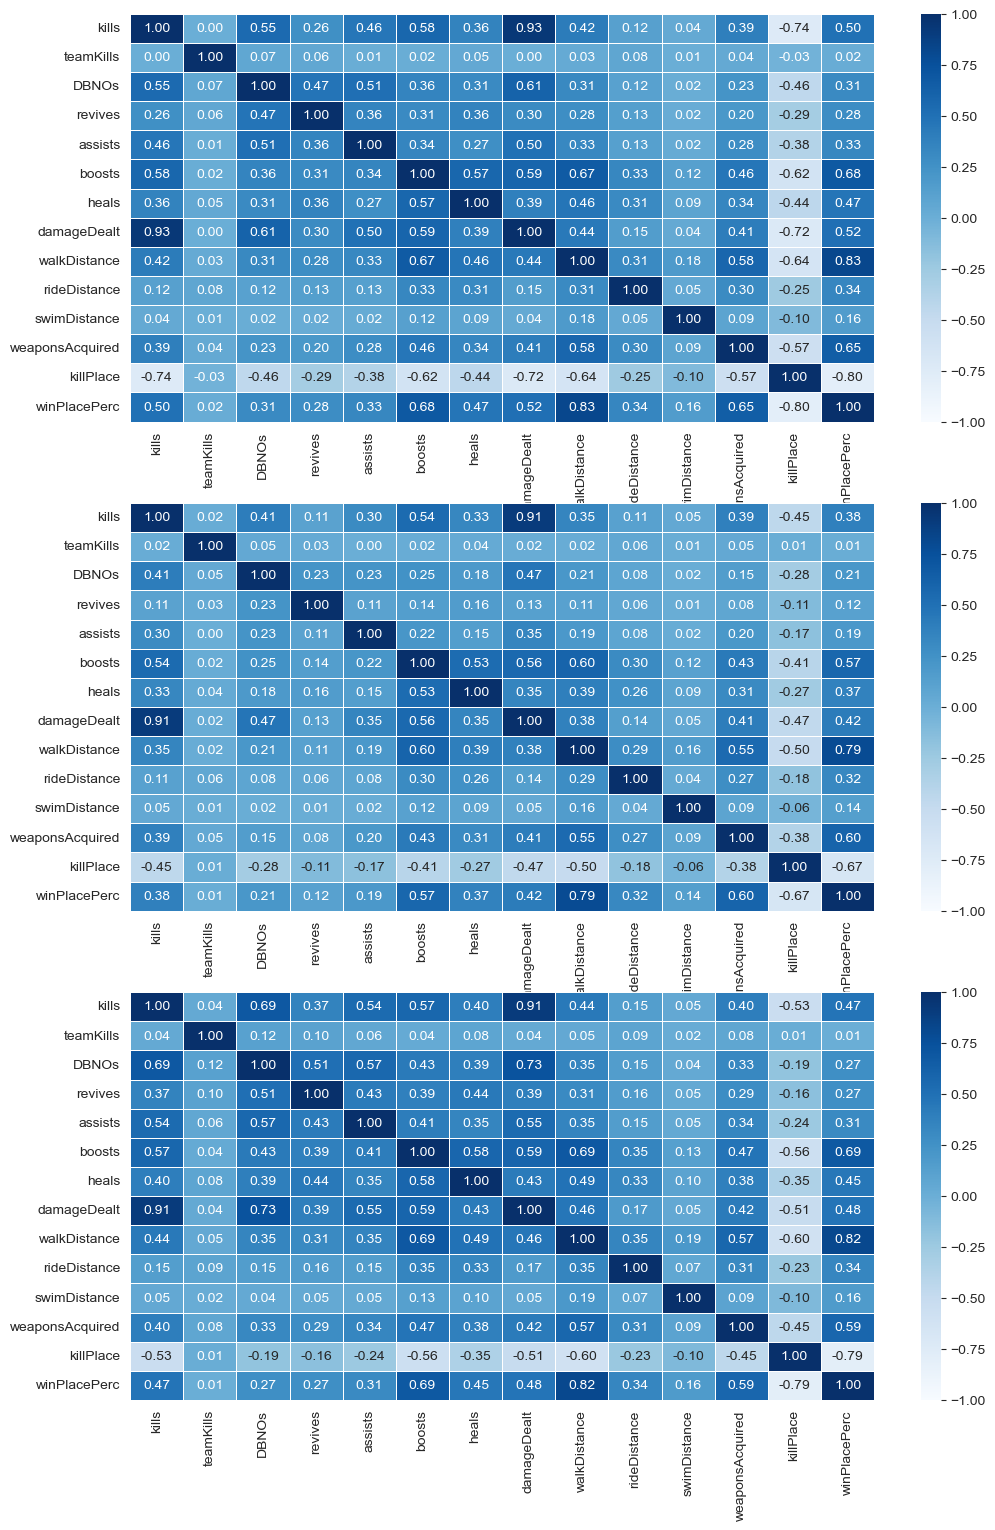

In [50]:
cols = ['kills','teamKills','DBNOs','revives','assists','boosts','heals','damageDealt',
    'walkDistance','rideDistance','swimDistance','weaponsAcquired']
cols.extend(['killPlace','winPlacePerc'])
group = train.groupby(['matchId','groupId'])[cols]

fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharey=True)
for df, ax in zip([group.mean(), group.min(), group.max()], ax.ravel()):
    sns.heatmap(df.corr(), annot=True, linewidths=.6, fmt='.2f', vmax=1, vmin=-1, center=0, cmap='Blues', ax=ax)

del df

In [51]:
def printMatchStats(matchIds):
    for mid in matchIds:
        subMatch = train[train['matchId'] == mid]
        print('matchType:', subMatch['matchType'].values[0])

        grp1st = subMatch[subMatch['winPlacePerc'] == 1]
        grpOther = subMatch[subMatch['winPlacePerc'] != 1]
        print('players'.ljust(10), ' total:{:>3}  1st:{:>3}  other:{:>3}'.format(len(subMatch), len(grp1st), len(grpOther)))
        for c in ['kills','teamKills','roadKills','DBNOs','revives','assists']:
            print(c.ljust(10), ' total:{:>3}  1st:{:>3}  other:{:>3}'.format(subMatch[c].sum(), grp1st[c].sum(), grpOther[c].sum()))
        print('-' * 30)

In [52]:
sampleMid = train['matchId'].unique()[0:5]
printMatchStats(sampleMid)

matchType: squad
players     total: 96  1st:  4  other: 92
kills       total: 84  1st: 15  other: 69
teamKills   total:  4  1st:  0  other:  4
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 78  1st: 11  other: 67
revives     total: 14  1st:  2  other: 12
assists     total: 28  1st:  7  other: 21
------------------------------
matchType: squad
players     total: 91  1st:  4  other: 87
kills       total: 83  1st:  7  other: 76
teamKills   total:  1  1st:  0  other:  1
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 79  1st:  5  other: 74
revives     total: 17  1st:  3  other: 14
assists     total: 35  1st:  6  other: 29
------------------------------
matchType: duo
players     total: 98  1st:  2  other: 96
kills       total: 91  1st:  9  other: 82
teamKills   total:  0  1st:  0  other:  0
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 52  1st:  4  other: 48
revives     total:  7  1st:  2  other:  5
assists     total: 20  1st:  3  other: 17
-------

In [53]:
match = train.groupby(['matchId'])['Id'].count()
fullplayer = match[match == 100].reset_index()
sampleMid = fullplayer['matchId'][0:5]
printMatchStats(sampleMid)

matchType: duo
players     total:100  1st:  2  other: 98
kills       total: 95  1st:  6  other: 89
teamKills   total:  1  1st:  0  other:  1
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 59  1st:  2  other: 57
revives     total: 11  1st:  0  other: 11
assists     total: 22  1st:  0  other: 22
------------------------------
matchType: duo
players     total:100  1st:  2  other: 98
kills       total: 93  1st:  8  other: 85
teamKills   total:  3  1st:  0  other:  3
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 66  1st:  3  other: 63
revives     total: 16  1st:  1  other: 15
assists     total: 22  1st:  3  other: 19
------------------------------
matchType: squad
players     total:100  1st:  4  other: 96
kills       total: 90  1st: 10  other: 80
teamKills   total:  1  1st:  0  other:  1
roadKills   total:  0  1st:  0  other:  0
DBNOs       total: 89  1st:  8  other: 81
revives     total: 21  1st:  2  other: 19
assists     total: 35  1st:  6  other: 29
---------

In [54]:
all_data = train.append(test, sort=False).reset_index(drop=True)
del train, test
gc.collect()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2564\1815165107.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_data = train.append(test, sort=False).reset_index(drop=True)


98326

In [55]:
match = all_data.groupby('matchId')
all_data['killsPerc'] = match['kills'].rank(pct=True).values
all_data['killPlacePerc'] = match['killPlace'].rank(pct=True).values
all_data['walkDistancePerc'] = match['walkDistance'].rank(pct=True).values
#all_data['damageDealtPerc'] = match['damageDealt'].rank(pct=True).values
all_data['walkPerc_killsPerc'] = all_data['walkDistancePerc'] / all_data['killsPerc']

In [56]:
all_data['_totalDistance'] = all_data['rideDistance'] + all_data['walkDistance'] + all_data['swimDistance']

In [57]:
def fillInf(df, val):
    numcols = df.select_dtypes(include='number').columns
    cols = numcols[numcols != 'winPlacePerc']
    df[df == np.Inf] = np.NaN
    df[df == np.NINF] = np.NaN
    for c in cols: df[c].fillna(val, inplace=True)

In [58]:
all_data['_healthItems'] = all_data['heals'] + all_data['boosts']
all_data['_headshotKillRate'] = all_data['headshotKills'] / all_data['kills']
all_data['_killPlaceOverMaxPlace'] = all_data['killPlace'] / all_data['maxPlace']
all_data['_killsOverWalkDistance'] = all_data['kills'] / all_data['walkDistance']
#all_data['_killsOverDistance'] = all_data['kills'] / all_data['_totalDistance']
#all_data['_walkDistancePerSec'] = all_data['walkDistance'] / all_data['matchDuration']

fillInf(all_data, 0)

In [59]:
all_data.drop(['boosts','heals','killStreaks','DBNOs'], axis=1, inplace=True)
all_data.drop(['headshotKills','roadKills','vehicleDestroys'], axis=1, inplace=True)
all_data.drop(['rideDistance','swimDistance','matchDuration'], axis=1, inplace=True)
all_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)

In [60]:
match = all_data.groupby(['matchId'])
group = all_data.groupby(['matchId','groupId','matchType'])

# target feature (max, min)
agg_col = list(all_data.columns)
exclude_agg_col = ['Id','matchId','groupId','matchType','maxPlace','numGroups','winPlacePerc']
for c in exclude_agg_col:
    agg_col.remove(c)
print(agg_col)

# target feature (sum)
sum_col = ['kills','killPlace','damageDealt','walkDistance','_healthItems']

['assists', 'damageDealt', 'killPlace', 'kills', 'longestKill', 'revives', 'teamKills', 'walkDistance', 'weaponsAcquired', 'killsPerc', 'killPlacePerc', 'walkDistancePerc', 'walkPerc_killsPerc', '_totalDistance', '_healthItems', '_headshotKillRate', '_killPlaceOverMaxPlace', '_killsOverWalkDistance']


In [61]:
match_data = pd.concat([
    match.size().to_frame('m.players'), 
    match[sum_col].sum().rename(columns=lambda s: 'm.sum.' + s), 
    match[sum_col].max().rename(columns=lambda s: 'm.max.' + s),
    match[sum_col].mean().rename(columns=lambda s: 'm.mean.' + s)
    ], axis=1).reset_index()
match_data = pd.merge(match_data, 
    group[sum_col].sum().rename(columns=lambda s: 'sum.' + s).reset_index())
match_data = reduce_mem_usage(match_data)

print(match_data.shape)

Memory usage of dataframe is 408.37 MB --> 288.92 MB (Decreased by 29.3%)
(2912982, 24)


In [62]:
''' ranking of kills and killPlace in each match
'''
minKills = all_data.sort_values(['matchId','groupId','kills','killPlace']).groupby(
    ['matchId','groupId','kills']).first().reset_index().copy()
for n in np.arange(4):
    c = 'kills_' + str(n) + '_Place'
    nKills = (minKills['kills'] == n)
    minKills.loc[nKills, c] = minKills[nKills].groupby(['matchId'])['killPlace'].rank().values
    match_data = pd.merge(match_data, minKills[nKills][['matchId','groupId',c]], how='left')
    #match_data[c].fillna(0, inplace=True)
match_data = reduce_mem_usage(match_data)
del minKills, nKills

print(match_data.shape)

Memory usage of dataframe is 377.81 MB --> 333.36 MB (Decreased by 11.8%)
(2912982, 28)


In [63]:
match_data.head()

,matchId,m.players,m.sum.kills,m.sum.killPlace,m.sum.damageDealt,m.sum.walkDistance,m.sum._healthItems,m.max.kills,m.max.killPlace,m.max.damageDealt,...,matchType,sum.kills,sum.killPlace,sum.damageDealt,sum.walkDistance,sum._healthItems,kills_0_Place,kills_1_Place,kills_2_Place,kills_3_Place
0,0000a43bce5eec,95,90.000,"4,560.000","13,539.771","119,082.789",224.000,7,95,983.700,...,squad,2.000,82.000,219.350,263.370,2.000,13.000,NaN,6.000,NaN
1,0000a43bce5eec,95,90.000,"4,560.000","13,539.771","119,082.789",224.000,7,95,983.700,...,squad,0.000,543.000,287.930,119.591,0.000,21.000,NaN,NaN,NaN
2,0000a43bce5eec,95,90.000,"4,560.000","13,539.771","119,082.789",224.000,7,95,983.700,...,squad,0.000,189.000,0.000,9.636,0.000,22.000,NaN,NaN,NaN
3,0000a43bce5eec,95,90.000,"4,560.000","13,539.771","119,082.789",224.000,7,95,983.700,...,squad,0.000,119.000,23.400,"1,118.100",1.000,12.000,NaN,NaN,NaN
4,0000a43bce5eec,95,90.000,"4,560.000","13,539.771","119,082.789",224.000,7,95,983.700,...,squad,6.000,28.000,681.900,"6,585.000",9.000,NaN,1.000,NaN,NaN


In [64]:
all_data = pd.concat([
    group.size().to_frame('players'),
    group.mean(),
    group[agg_col].max().rename(columns=lambda s: 'max.' + s),
    group[agg_col].min().rename(columns=lambda s: 'min.' + s),
    ], axis=1).reset_index()
all_data = reduce_mem_usage(all_data)

print(all_data.shape)

Memory usage of dataframe is 911.20 MB --> 591.72 MB (Decreased by 35.1%)
(2912982, 61)


In [65]:
numcols = all_data.select_dtypes(include='number').columns.values
numcols = numcols[numcols != 'winPlacePerc']

In [66]:
''' match summary, max
'''
all_data = pd.merge(all_data, match_data)
del match_data
gc.collect()

all_data['enemy.players'] = all_data['m.players'] - all_data['players']
for c in sum_col:
    #all_data['enemy.' + c] = (all_data['m.sum.' + c] - all_data['sum.' + c]) / all_data['enemy.players']
    #all_data['p.sum_msum.' + c] = all_data['sum.' + c] / all_data['m.sum.' + c]
    #all_data['p.max_mmean.' + c] = all_data['max.' + c] / all_data['m.mean.' + c]
    all_data['p.max_msum.' + c] = all_data['max.' + c] / all_data['m.sum.' + c]
    all_data['p.max_mmax.' + c] = all_data['max.' + c] / all_data['m.max.' + c]
    all_data.drop(['m.sum.' + c, 'm.max.' + c], axis=1, inplace=True)
    
fillInf(all_data, 0)
print(all_data.shape)

(2912982, 87)


In [67]:
''' match rank
'''
match = all_data.groupby('matchId')
matchRank = match[numcols].rank(pct=True).rename(columns=lambda s: 'rank.' + s)
all_data = reduce_mem_usage(pd.concat([all_data, matchRank], axis=1))
rank_col = matchRank.columns
del matchRank
gc.collect()

# instead of rank(pct=True, method='dense')
match = all_data.groupby('matchId')
matchRank = match[rank_col].max().rename(columns=lambda s: 'max.' + s).reset_index()
all_data = pd.merge(all_data, matchRank)
for c in numcols:
    all_data['rank.' + c] = all_data['rank.' + c] / all_data['max.rank.' + c]
    all_data.drop(['max.rank.' + c], axis=1, inplace=True)
del matchRank
gc.collect()

print(all_data.shape)

Memory usage of dataframe is 2186.31 MB --> 1519.59 MB (Decreased by 30.5%)
(2912982, 144)


In [68]:
''' TODO: incomplete
''' 
killMinorRank = all_data[['matchId','min.kills','max.killPlace']].copy()
group = killMinorRank.groupby(['matchId','min.kills'])
killMinorRank['rank.minor.maxKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

killMinorRank = all_data[['matchId','max.kills','min.killPlace']].copy()
group = killMinorRank.groupby(['matchId','max.kills'])
killMinorRank['rank.minor.minKillPlace'] = group.rank(pct=True).values
all_data = pd.merge(all_data, killMinorRank)

del killMinorRank
gc.collect()

0

In [69]:
# drop constant column
constant_column = [col for col in all_data.columns if all_data[col].nunique() == 1]
print('drop columns:', constant_column)
all_data.drop(constant_column, axis=1, inplace=True)

drop columns: ['rank.maxPlace', 'rank.numGroups']


In [70]:
'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
all_data['matchType'] = all_data['matchType'].apply(mapper)

all_data = pd.concat([all_data, pd.get_dummies(all_data['matchType'])], axis=1)
all_data.drop(['matchType'], axis=1, inplace=True)

all_data['matchId'] = all_data['matchId'].apply(lambda x: int(x,16))
all_data['groupId'] = all_data['groupId'].apply(lambda x: int(x,16))

In [71]:
null_cnt = all_data.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

winPlacePerc    886238
dtype: int64


In [72]:
#all_data.drop([],axis=1,inplace=True)

cols = [col for col in all_data.columns if col not in ['Id','matchId','groupId']]
for i, t in all_data.loc[:, cols].dtypes.iteritems():
    if t == object:
        all_data[i] = pd.factorize(all_data[i])[0]

all_data = reduce_mem_usage(all_data)
all_data.head()

Memory usage of dataframe is 1527.92 MB --> 1530.70 MB (Decreased by -0.2%)


,matchId,groupId,players,assists,damageDealt,killPlace,kills,longestKill,maxPlace,numGroups,...,rank.min._totalDistance,rank.min._healthItems,rank.min._headshotKillRate,rank.min._killPlaceOverMaxPlace,rank.min._killsOverWalkDistance,rank.minor.maxKillPlace,rank.minor.minKillPlace,duo,solo,squad
0,705378017004,6950488777545910,2,0.000,109.675,41.000,1.000,6.275,28.000,28.000,...,0.286,0.625,0.500,0.429,0.411,0.591,1.000,0.000,0.000,1.000
1,705378017004,9968970908074425,6,0.000,47.988,90.500,0.000,0.000,28.000,28.000,...,0.054,0.286,0.500,0.964,0.411,0.955,0.900,0.000,0.000,1.000
2,705378017004,16443050264754488,2,0.000,0.000,94.500,0.000,0.000,28.000,28.000,...,0.054,0.286,0.500,1.000,0.411,1.000,1.000,0.000,0.000,1.000
3,705378017004,21374959510965402,2,0.000,11.700,59.500,0.000,0.000,28.000,28.000,...,0.429,0.286,0.500,0.821,0.411,0.545,0.500,0.000,0.000,1.000
4,705378017004,21704066427752580,2,1.000,340.950,14.000,3.000,25.230,28.000,28.000,...,0.964,0.839,1.000,0.143,0.821,0.333,1.000,0.000,0.000,1.000


In [73]:
X_train = all_data[all_data['winPlacePerc'].notnull()].reset_index(drop=True)
X_test = all_data[all_data['winPlacePerc'].isnull()].drop(['winPlacePerc'], axis=1).reset_index(drop=True)

del all_data
gc.collect()

Y_train = X_train.pop('winPlacePerc')
X_test_grp = X_test[['matchId','groupId']].copy()
train_matchId = X_train['matchId']

# drop matchId,groupId
X_train.drop(['matchId','groupId'], axis=1, inplace=True)
X_test.drop(['matchId','groupId'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(2026744, 143) (886238, 143)


In [74]:
print(pd.DataFrame([[val for val in dir()], [sys.getsizeof(eval(val)) for val in dir()]],
                   index=['name','size']).T.sort_values('size', ascending=False).reset_index(drop=True)[:10])

            name        size
0        X_train  1059987256
1         X_test   463502618
2  train_matchId    16214096
3     X_test_grp    14179952
4        Y_train     8107120
5            sub      378189
6     fullplayer      111850
7         subset       32026
8       subMatch       31461
9        sub_grp       21136


In [75]:
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import minmax_scale
from sklearn import tree

# import lightgbm as lgb

# params={'learning_rate': 0.05,
#         'objective':'mae',
#         'metric':'mae',
#         'num_leaves': 128,
#         'verbose': 1,
#         'random_state':42,
#         'bagging_fraction': 0.7,
#         'feature_fraction': 0.7
#        }

tree = tree.DecisionTreeRegressor()
# reg = lgb.LGBMRegressor(**params, n_estimators=10000)
tree.fit(X_train, Y_train)
pred = tree.predict(X_test)

In [84]:
data = pd.Series(pred)
data.to_excel('sheet.')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2564\1370215680.py:2: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  data.to_excel('sheet.xls')


ModuleNotFoundError: No module named 'xlwt'

In [76]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
sorted_idx = sorted_idx[len(feature_importance) - 30:]
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

NameError: name 'reg' is not defined

In [ ]:
X_train.columns[np.argsort(-feature_importance)].values

In [ ]:
X_test_grp['_nofit.winPlacePerc'] = pred

group = X_test_grp.groupby(['matchId'])
X_test_grp['winPlacePerc'] = pred
X_test_grp['_rank.winPlacePerc'] = group['winPlacePerc'].rank(method='min')
X_test = pd.concat([X_test, X_test_grp], axis=1)

In [ ]:
fullgroup = (X_test['numGroups'] == X_test['maxPlace'])

# full group (201366) --> calculate from rank
subset = X_test.loc[fullgroup]
X_test.loc[fullgroup, 'winPlacePerc'] = (subset['_rank.winPlacePerc'].values - 1) / (subset['maxPlace'].values - 1)

# not full group (684872) --> align with maxPlace
subset = X_test.loc[~fullgroup]
gap = 1.0 / (subset['maxPlace'].values - 1)
new_perc = np.around(subset['winPlacePerc'].values / gap) * gap  # half&up
X_test.loc[~fullgroup, 'winPlacePerc'] = new_perc

X_test['winPlacePerc'] = X_test['winPlacePerc'].clip(lower=0,upper=1)

In [ ]:
# edge cases
X_test.loc[X_test['maxPlace'] == 0, 'winPlacePerc'] = 0
X_test.loc[X_test['maxPlace'] == 1, 'winPlacePerc'] = 1  # nothing
X_test.loc[(X_test['maxPlace'] > 1) & (X_test['numGroups'] == 1), 'winPlacePerc'] = 0
X_test['winPlacePerc'].describe()